In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
est_tz = pytz.timezone('US/Eastern')
def utc_to_est(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(est_tz)
    return est_tz.normalize(local_dt)

In [6]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [7]:
def load_and_clean_transcripts():
    client = MongoClient('localhost', 27017)
    earnings_transcript_collection = client.python_import.earnings_transcript
    
    earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
    earnings_transcript.drop('_id', axis=1, inplace=True)
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: utc_to_est(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['publishDate_str'] = earnings_transcript.apply(
        lambda row: str(row['shifted_publishDate'].date()), axis=1
    )
    earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
    
    return earnings_transcript

In [8]:
earnings_transcript = load_and_clean_transcripts()

In [9]:
earnings_transcript.head(2)

,,publishDate,qAndAText,rawText,url,shifted_publishDate
tradingSymbol,publishDate_str,,,,,
A,2014-11-18,2014-11-17T22:25:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/2675895-agile...,2014-11-18 17:25:00-05:00
AA,2014-10-09,2014-10-09T01:18:03Z,Operator [Operator instructions.] Our first qu...,Alcoa (NYSE: AA ) Q3 2014 Results Earnings Con...,https://seekingalpha.com/article/2549515-alcoa...,2014-10-09 21:18:03-04:00


In [10]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
ABG           2016-02-04       2016-02-04T19:43:07Z   
              2016-04-26       2016-04-26T13:55:00Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
ABG           2016-02-04       Operator Thank you. And we will take our first...   
              2016-04-26                                                           

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
ABG           2016-02-04       Asbury Automotive Group, Inc. (NYSE: ABG ) Q4 ...   
              2016-04-26       Earnings Conference Call Start time: April 26,...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
ABG           2016-02-04       https://seekingalpha.com/article/3866076-asbur...   
              2016-04-26       https://seekingalpha.com/article/3967725-asbur...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
ABG           2016-02-04      2016-02-04 14:43:07-05:00  
              2016-04-26      2016-04-26 09:55:00-04:00

### Load all ticker data for transcripts

In [11]:
earnings_transcript.index.levels[0]

Index(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV',
       'ABC', 'ABCB', 'ABG', 'ABM'],
      dtype='object', name='tradingSymbol')

In [12]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [13]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
for ticker in tickers:
    stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} is not available'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)

A ticker has 4341 long list
AA ticker has 4341 long list
AAN ticker has 4341 long list
AAON ticker has 4341 long list
AAP ticker has 3863 long list
AAPL ticker has 4341 long list
AAT ticker has 1566 long list
AAWW ticker has 2869 long list
ABAX ticker has 4341 long list
ABBV ticker has 1072 long list
ABC ticker has 4341 long list
ABCB ticker has 4341 long list
ABG ticker has 3787 long list
ABM ticker has 4341 long list


In [14]:
all_stocks.sample(20)

Close   Std Dev  1day return  5day return  \
tradingSymbol publishDate_str                                                   
ABG           2010-04-07        13.990000  0.279301    -0.390000    -0.130000   
AAON          2011-08-24         7.042169  0.960690    -0.353367     0.323921   
AAPL          2008-06-18        23.158770  0.649334     0.278553    -0.176201   
ABG           2007-06-22        24.081673  1.093052    -0.168011    -0.793388   
A             2013-06-11        30.489041  0.500545    -0.329611     0.274676   
ABC           2011-07-01        38.747282  0.395096     0.147188     0.174788   
              2010-01-22        24.112070  0.378604     0.406993     0.542657   
AAP           2016-04-22       158.155755  2.431890    -1.008437    -2.296441   
ABAX          2007-05-17        19.520003  1.383506     0.161009     1.231246   
ABG           2013-04-16        35.599998  0.939949    -0.750000    -0.049999   
AAPL          2017-01-31       120.826147  1.796004     7.368056    10.136054   
ABBV          2016-10-13        60.539169  0.906034    -0.970214     0.603904   
AAON          2014-01-31        19.282987  0.676010    -1.066217    -1.183242   
ABCB          2009-12-23         6.465827  0.118668     0.028690     0.435261   
AAON          2000-05-18         1.655030  0.041910    -0.023852     0.033388   
ABG           2009-01-21         3.540000  0.548780    -0.040000     0.590000   
AAN           2005-04-19        10.433433  0.569399     0.019321    -0.083728   
A             2008-06-19        25.694412  0.355612    -0.223725    -1.491497   
ABM           2010-08-18        17.766574  0.570670    -1.077280    -1.196979   
ABG           2010-03-26        13.960000  0.712401    -0.280000    -0.130000   

                               1day label  5day label  1day significant label  \
tradingSymbol publishDate_str                                                   
ABG           2010-04-07               -1          -1                      -1   
AAON          2011-08-24               -1           1                       0   
AAPL          2008-06-18                1          -1                       0   
ABG           2007-06-22               -1          -1                       0   
A             2013-06-11               -1           1                       0   
ABC           2011-07-01                1           1                       0   
              2010-01-22                1           1                       1   
AAP           2016-04-22               -1          -1                       0   
ABAX          2007-05-17                1           1                       0   
ABG           2013-04-16               -1          -1                       0   
AAPL          2017-01-31                1           1                       1   
ABBV          2016-10-13               -1           1                      -1   
AAON          2014-01-31               -1          -1                      -1   
ABCB          2009-12-23                1           1                       0   
AAON          2000-05-18               -1           1                       0   
ABG           2009-01-21               -1           1                       0   
AAN           2005-04-19                1          -1                       0   
A             2008-06-19               -1          -1                       0   
ABM           2010-08-18               -1          -1                      -1   
ABG           2010-03-26               -1          -1                       0   

                               5day significant label  
tradingSymbol publishDate_str                          
ABG           2010-04-07                            0  
AAON          2011-08-24                            0  
AAPL          2008-06-18                            0  
ABG           2007-06-22                            0  
A             2013-06-11                            0  
ABC           2011-07-01                            0  
              2010-01-

# Merge transcripts with stock data

In [15]:
merged_data = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
merged_data.sample(5)

,,publishDate,qAndAText,rawText,url,shifted_publishDate,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,,,,,,
A,2009-05-15,2009-05-15T03:50:33Z,Operator Certainly. (Operator Instructions) Yo...,Agilent Technologies Inc. (NYSE: A ) F2Q09 Ear...,https://seekingalpha.com/article/137791-agilen...,2009-05-15 23:50:33-04:00,11.965868,0.711619,0.149149,0.027118,1,1,0,0
AAPL,2013-04-24,2013-04-23T22:46:07Z,Operator (Operator Instructions) First we’ll g...,Apple Inc. (NASDAQ: AAPL ) F2Q13 Earnings Conf...,https://seekingalpha.com/article/1364041-apple...,2013-04-24 18:46:07-04:00,53.306587,2.208446,0.383900,4.447696,1,1,0,1
AAP,2016-05-19,2016-05-19T18:27:09Z,Operator Thank you. We will now begin the ques...,"Advance Auto Parts, Inc. (NYSE: AAP ) Q1 2016 ...",https://seekingalpha.com/article/3976413-advan...,2016-05-19 14:27:09-04:00,143.318667,5.256864,2.845612,13.099781,1,1,0,1
ABC,2014-10-31,2014-10-30T20:10:10Z,Operator [Operator Instructions] We'll go to t...,AmerisourceBergen (NYSE: ABC ) Q4 2014 Earning...,https://seekingalpha.com/article/2619685-ameri...,2014-10-31 16:10:10-04:00,82.397020,2.695341,1.437435,1.273434,1,1,0,0
AAP,2016-08-16,2016-08-16T18:47:28Z,Operator [Operator Instructions]. The first q...,"Advance Auto Parts, Inc. (NYSE: AAP ) Q2 2016 ...",https://seekingalpha.com/article/4000006-advan...,2016-08-16 14:47:28-04:00,160.215656,2.527540,-2.347290,-2.457164,-1,-1,0,0


In [17]:
shorts = merged_data[merged_data['rawText'].apply(len) < 5000]

In [18]:
len(shorts)

78

In [19]:
merged_data = merged_data[merged_data['rawText'].apply(len) > 5000]

# Create train data and test data

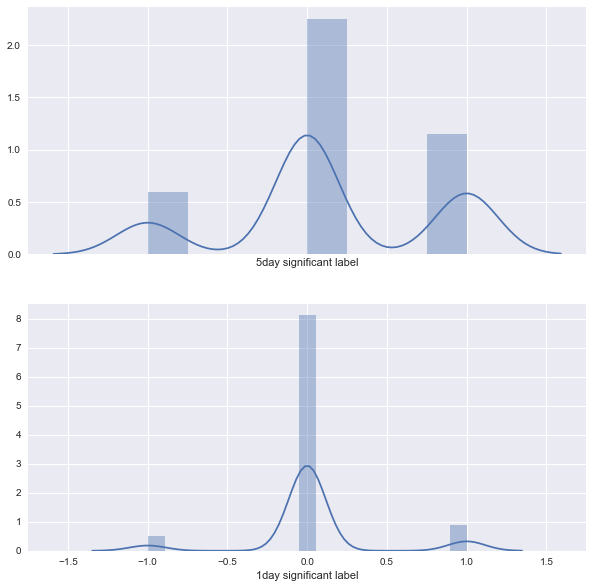

In [20]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
sns.distplot(merged_data['5day significant label'], ax=ax1)
sns.distplot(merged_data['1day significant label'], ax=ax2)

In [21]:
merged_data['5day significant label'].value_counts()

 0    215
 1    110
-1     57
Name: 5day significant label, dtype: int64

In [22]:
X = merged_data['rawText']
y = merged_data['5day significant label'] + 1

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [24]:
tfidf = TfidfVectorizer(max_df=0.35, min_df=2, ngram_range=(1,3), stop_words='english')

In [25]:
tfidf_vectors = tfidf.fit_transform(X_train)

In [26]:
classifier = learn.DNNClassifier(hidden_units=[200,300,200], n_classes=3, 
                                 feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_save_checkpoints_steps': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000019A0CB95C50>, '_save_checkpoints_secs': 600, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_is_chief': True, '_environment': 'local', '_evaluation_master': ''}


In [27]:
classifier.fit(tfidf_vectors.todense(), y_train, batch_size=20, steps=600)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmp5ojc8i8b\model.ckpt.
INFO:tensorflow:loss = 1.09886, step = 1
INFO:tensorflow:global_step/sec: 3.36363
INFO:tensorflow:loss = 0.79263, step = 101
INFO:tensorflow:global_step/sec: 3.13058
INFO:tensorflow:loss = 0.662582, step = 201
INFO:tensorflow:global_step/sec: 3.01616
INFO:tensorflow:loss = 0.324865, step = 301
INFO:tensorflow:global_step/sec: 2.94625
INFO:tensorflow:loss = 0.0714979, step = 401
INFO:tensorflow:global_step/sec: 3.07125
INFO:tensorflow:loss = 0.00994844, step = 501
INFO:tensorflow:Saving checkpoints for 600 into C:\Use

DNNClassifier(params={'gradient_clip_norm': None, 'input_layer_min_slice_size': None, 'dropout': None, 'activation_fn': <function relu at 0x0000019A09B730D0>, 'embedding_lr_multipliers': None, 'hidden_units': [200, 300, 200], 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x0000019A19C7B198>, 'optimizer': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=198209, default_value=None, dtype=tf.float32, normalizer=None),)})

In [28]:
y_predicted = list(classifier.predict(tfidf.transform(X_test).todense()))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [29]:
cm = confusion_matrix(y_test, y_predicted)

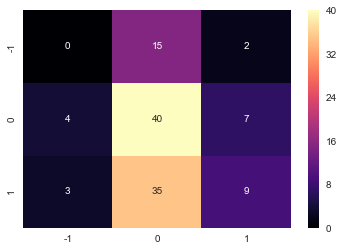

In [36]:
sns.heatmap(cm, cmap='magma', annot=True, xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])

In [31]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        17
          1       0.44      0.78      0.57        51
          2       0.50      0.19      0.28        47

avg / total       0.40      0.43      0.36       115



# Playground

In [33]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['zyprexa generics', 'operating businesses', 'operating capacities', 'discipline investing key', 'discipline investing', 'discipline focus', 'discipline continue', 'operating cash generation', 'discipline comes', 'operating changes']


### LogReg backtest

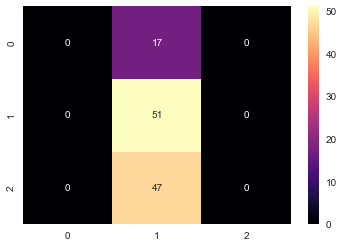

In [34]:
classifier2 = LogisticRegression()
classifier2.fit(tfidf_vectors, y_train)
y_predicted2 = classifier2.predict(tfidf.transform(X_test))
sns.heatmap(confusion_matrix(y_test, y_predicted2), cmap='magma', annot=True)